# Classification of Sleep Stages using ECG and Respiration Signals

The goal of this notebook is to demonstrate the classification of sleep stages using electrocardiogram (ECG) and respiration signals obtained from polysomnograph databases. This notebook includes (i) extraction of features from the physiological signals, (ii) selection of useful features, (iii) model training, and (iv) model selection. 

In [1]:
from __future__ import division
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as ss
from scipy.stats import skew, kurtosis
import itertools
import pickle
import glob
import seaborn as sns
import time
from copy import deepcopy

import wfdb
from biosppy.signals import ecg
import nolds
import sampen

import sleep_utils as su

%matplotlib inline
sns.set()
pd.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

### Load MIT-BIH Polysomnographic Database
Database source: https://www.physionet.org/physiobank/database/slpdb/

In [3]:
data_dir = '../data/PSG_database/'

sleep_data_sigs = {}
sleep_data_fields = {}

data_keys = []
for fname in glob.iglob(data_dir + '/*.dat'):#, recursive=True):
    # filename manipulation
    base = os.path.basename(fname)
    key = os.path.splitext(base)[0]
    data_keys.append(key)
    
    # load data
    sig, fields=wfdb.rdsamp(data_dir+key)
    sleep_data_sigs[key] = sig
    sleep_data_fields[key] = fields

#### * Annotations*
   * W: subject is awake
   * 1: sleep stage 1
   * 2: sleep stage 2
   * 3: sleep stage 3
   * 4: sleep stage 4
   * R: REM sleep
   * MT: Movement time

In [4]:
# load labels 
ann_index = {}
ann_labels = {}

set_stages = set()
for key in data_keys:
    annotation = wfdb.rdann(data_dir + key, 'st')
    ann_index_sig = annotation[0]
    ann_label_sig = annotation[5]
    label_filt = [(x, y) for x, y in zip(ann_index_sig, ann_label_sig) if x >1 ]
    unzipped = zip(*label_filt)
    ann_index[key] = unzipped[0]
    ann_labels[key] = unzipped[1]


#### *Compile signals from different patients*

In [5]:
resp_data_set = {}
ecg_data_set = {}
time_data_set = {}
annot_data_set = {}

fs = 250

for key in data_keys:
    
    resp_data_set[key] = (sleep_data_sigs[key])[:, (sleep_data_fields[key])['signame'].index('Resp')]
    ecg_data_set[key] = (sleep_data_sigs[key])[:, (sleep_data_fields[key])['signame'].index('ECG')]
    time_data_set[key] = np.arange(0, len(resp_data_set[key]))/fs

    # Note: Only the first character of the annotation was taken as label
    # Example: 1, 2, 3, 4, R, W, M
    stages_list = [x.rsplit(' ')[0][0] for x in ann_labels[key]]

    annot_data_set[key] = stages_list


## I. Feature extraction

### *Features from Previous Stage*

In [6]:
# feature_prev_stage = {}
# feature_prev_stage_light = {}
# feature_prev_stage_deep = {}
# feature_prev_stage_rem = {}
# feature_prev_stage_wake = {}
# feature_prev_stage_move = {}

# for key in data_keys:
#     previous = annot_data_set[key][1:]
#     prev_stage = [np.nan] + previous
#     feature_prev_stage[key] = {'_feat' : prev_stage}
    
#     # NREM-light or not
#     feature_prev_stage_light[key] = [np.nan] +map(lambda x: 0 if x not in ['1', '2'] else 1, previous)
    
#     # NREM-deep or not
#     feature_prev_stage_deep[key] = [np.nan] +map(lambda x: 0 if x not in ['3', '4'] else 1, previous)
    
#     # REM or not
#     feature_prev_stage_rem[key] = [np.nan] + map(lambda x: 0 if x!= 'R' else 1,previous)
    
#     # Wake or not
#     feature_prev_stage_wake[key] = [np.nan] + map(lambda x: 0 if x!= 'W' else 1,previous)
    
#     # Wake or not
#     feature_prev_stage_move[key] = [np.nan] + map(lambda x: 0 if x!= 'M' else 1,previous)


*NOTE: Stages are annotated for every 30 seconds. The physiological signals will be divided into 30-second epochs/windows, and the features will be computed for every window. *

In [7]:
win_dur = 30 # duration of window, unit: seconds, size of one epoch 
win_size = fs*win_dur # length of window
win_step = 1 # duration by which the window slides, unit: seconds
win_int = win_step*fs # length by which the window slides

#### *Pre-process respiration signals and divide into 30-second epochs/windows*

In [8]:
# Respiratory frequency range 
min_normrange = 4/60 # unit: cycles per second
max_normrange = 65/60 # unit: cycles per second

resp_data_set_epochs = {}

# Divide respiration data per 30-second epoch. 

for key in data_keys:
    resp_sig = resp_data_set[key]
    fft_resp = np.fft.fft(resp_sig)
    fft_freqs = np.fft.fftfreq(len(resp_sig), 1/fs)
    
    # Remove frequencies which are outside the expected range
    fft_resp[abs(fft_freqs) < min_normrange] = 0
    fft_resp[abs(fft_freqs) > max_normrange] = 0
    
    resp_filt_sig = np.real(np.fft.ifft(fft_resp))
    time_sig = np.arange(len(resp_sig))/fs

    # Divide into windows
    resp_windows = su.divide_to_epochs(resp_filt_sig, ann_index[key], win_dur, fs)
    time_windows = su.divide_to_epochs(time_sig, ann_index[key], win_dur, fs)
    
    resp_data_set_epochs[key] = pd.DataFrame({'resp': list(resp_windows), '_time': list(time_windows)})


In [9]:
# Divide ECG data per 30-second epoch. 

ecg_data_set_epochs = {}

for key in data_keys:
    ecg_sig = ecg_data_set[key]
    time_sig = np.arange(len(ecg_sig))/fs

    # Divide into windows
    ecg_windows = su.divide_to_epochs(ecg_sig, ann_index[key], win_dur, fs)
    time_windows = su.divide_to_epochs(time_sig, ann_index[key], win_dur, fs)
    
    ecg_data_set_epochs[key] = pd.DataFrame({'ecg': list(ecg_windows), '_time': list(time_windows)})

### *Features from Respiration Signal*

1. Respiration rate (frequency corresponding to the highest peak in the epoch's power spectrum)
2. Mean magnitude
3. Minimum magnitude
4. Maximum magnitude 
5. Standard deviation of magnitudes
6. Ratio of standard deviation and mean of magnitude
7. Ratio of mean and standard deviation of peak-to-peak duration of respiration signal
8. Ratio of mean and standard deviation of amplitude of respiration signal
9. Ratio of max and mean of magnitude of amplitude of respiration signal
10. Ratio of min and mean of magnitude of amplitude of respiration 
11. Sample entropy of manitude of respiration signal
12. Number of zero crossings 
13. Kurtosis
14. Skewness

In [10]:
# feature_resp_rate = {}
# feature_mean_mag_resp = {}
# feature_min_mag_resp = {}
# feature_max_mag_resp = {}
# feature_stdev_mag_resp = {}
# feature_std_vs_mean_resp = {}
# feature_mean_vs_std_p2p_dur_resp = {}
# feature_mean_vs_std_amp_resp = {}
# feature_max_vs_mean_amp_resp = {}
# feature_min_vs_mean_amp_resp = {}
# feature_sampen_resp = {}
# feature_zerocross_resp = {}
# feature_kurtosis_resp = {}
# feature_skew_resp = {}

# for key in data_keys:
#     resp_data = resp_data_set_epochs[key]
#     resp_data['power_spectrum'] = resp_data.resp.apply(lambda x: ss.periodogram(x, fs=fs))
    
#     # Respiration rate
#     resp_data['resp_rate'] = resp_data.power_spectrum.apply(lambda x: (x[0])[np.argmax(x[1])]*60)
#     feature_resp_rate[key] = resp_data.resp_rate.values
    
#     # Mean of magnitudes
#     feature_mean_mag_resp[key] = resp_data.resp.apply(lambda x: np.nanmean(x)).values

#     # Minimum magnitude
#     feature_min_mag_resp[key] = resp_data.resp.apply(lambda x: np.nanmin(x)).values

#     # Maximum magnitude
#     feature_max_mag_resp[key] = resp_data.resp.apply(lambda x: np.nanmax(x)).values
    
#     # Standard deviation of magnitude
#     feature_stdev_mag_resp[key] = resp_data.resp.apply(lambda x: np.std(x)).values
    
#     # Mean vs standard deviation of magnitude
#     feature_std_vs_mean_resp[key] = resp_data.resp.apply(lambda x: np.nanstd(x)/np.nanmean(x)).values

#     # Mean vs standard deviation of peak-to-peak duration
#     p2p_dur = resp_data.resp.apply(lambda x: su.bio_signal_peak_detect(x, fs, 'resp'))\
#                             .apply(lambda x: np.array(x[0][1:]) - np.array(x[0][:-1]))
#     feature_mean_vs_std_p2p_dur_resp[key] = p2p_dur.apply(lambda x: np.nanmean(x)/np.nanstd(x)).values    

#     # Mean vs stdev of amplitude of respiration signal
#     amplitude = resp_data.resp.apply(lambda x: su.compute_amplitude(x, fs, 'resp'))
#     feature_mean_vs_std_amp_resp[key] = amplitude.apply(lambda x: np.nanmean(x)/np.nanstd(x)).values
    
#     # Max vs stdev of amplitude of respiration signal
#     feature_max_vs_mean_amp_resp[key] = amplitude.apply(lambda x: np.nanmax(x)/np.nanmean(x)).values
    
#     # Min vs stdev of amplitude of respiration signal
#     feature_min_vs_mean_amp_resp[key] = amplitude.apply(lambda x: np.nanmax(x)/np.nanmean(x)).values
    
#     # Sample entropy of respiration signal
#     feature_sampen_resp[key] = resp_data.resp.apply(lambda x: (nolds.sampen(x))).values     
    
#     # Number of zero crossings
#     feature_zerocross_resp[key] = resp_data.resp.apply(lambda x: su.Zero_Crossing_Counts(x)).values     
    
#     # Kurtosis
#     feature_kurtosis_resp[key] = resp_data.resp.apply(lambda x: kurtosis(x)).values     
    
#     # Skew
#     feature_skew_resp[key] = resp_data.resp.apply(lambda x: skew(x)).values     
    
#     print('Done computing features for ' + key + '.')


### *Features from ECG Signal*

1. Heart rate
2. Heart rate variability
3. Mean magnitude
4. Minimum magnitude
5. Maximum magnitude 
6. Standard deviation of magnitudes
7. Ratio of standard deviation and mean of magnitude
8. Ratio of mean and standard deviation of peak-to-peak duration of ECG signal
9. Ratio of mean and standard deviation of amplitude of ECG signal
10. Ratio of max and mean of magnitude of amplitude of ECG signal
11. Ratio of min and mean of magnitude of amplitude of ECG signal
12. Sample entropy of manitude of ECG signal
13. Number of zero crossings 
14. Kurtosis
15. Skewness

In [11]:
# feature_heart_rate = {}
# feature_heart_rate_var = {}
# feature_mean_mag_ecg = {}
# feature_min_mag_ecg = {}
# feature_max_mag_ecg = {}
# feature_stdev_mag_ecg = {}
# feature_std_vs_mean_ecg = {}
# feature_mean_vs_std_p2p_dur_ecg = {}
# feature_mean_vs_std_amp_ecg = {}
# feature_max_vs_mean_amp_ecg = {}
# feature_min_vs_mean_amp_ecg = {}
# feature_sampen_ecg = {}
# feature_zerocross_ecg = {}
# feature_kurtosis_ecg = {}
# feature_skew_ecg = {}

# for key in data_keys:
#     ecg_data = ecg_data_set_epochs[key]
    
#     # Get time corresponding to R peaks
#     ecg_data['r_peaks'] = ecg_data.ecg.apply(lambda x: ecg.hamilton_segmenter(x, sampling_rate=250)['rpeaks'])
#     ecg_data['r_time'] = ecg_data.apply(lambda x: list(x._time[x.r_peaks]), axis = 1)
    
#     # Heart rate
#     feature_heart_rate[key] = ecg_data.r_time.apply(lambda x: su.heart_rate(np.array(x))*60).values
        
#     # Heart rate variability
#     feature_heart_rate_var[key] = ecg_data.r_time.apply(lambda x: su.heart_rate_var(np.array(x))*1000).values
    
#     # Mean of magnitudes
#     feature_mean_mag_ecg[key] = ecg_data.ecg.apply(lambda x: np.nanmean(x)).values

#     # Minimum magnitude
#     feature_min_mag_ecg[key] = ecg_data.ecg.apply(lambda x: np.nanmin(x)).values

#     # Maximum magnitude
#     feature_max_mag_ecg[key] = ecg_data.ecg.apply(lambda x: np.nanmax(x)).values
    
#     # Standard deviation of magnitude
#     feature_stdev_mag_ecg[key] = ecg_data.ecg.apply(lambda x: np.std(x)).values
    
#     # Mean vs standard deviation of magnitude
#     feature_std_vs_mean_ecg[key] = ecg_data.ecg.apply(lambda x: np.nanstd(x)/np.nanmean(x)).values

#     # Mean vs standard deviation of peak-to-peak duration
#     p2p_dur = ecg_data.ecg.apply(lambda x: su.bio_signal_peak_detect(x, fs, 'ecg'))\
#                           .apply(lambda x: np.array(x[0][1:]) - np.array(x[0][:-1]))
#     feature_mean_vs_std_p2p_dur_ecg[key] = p2p_dur.apply(lambda x: np.nanmean(x)/np.nanstd(x)).values    

#     # Mean vs stdev of amplitude of ecg signal
#     amplitude = ecg_data.ecg.apply(lambda x: su.compute_amplitude(x, fs, 'ecg'))
#     feature_mean_vs_std_amp_ecg[key] = amplitude.apply(lambda x: np.nanmean(x)/np.nanstd(x)).values
    
#     # Max vs stdev of amplitude of respiration signal
#     feature_max_vs_mean_amp_ecg[key] = amplitude.apply(lambda x: np.nanmax(x)/np.nanmean(x)).values
    
#     # Min vs stdev of amplitude of respiration signal
#     feature_min_vs_mean_amp_ecg[key] = amplitude.apply(lambda x: np.nanmax(x)/np.nanmean(x)).values
    
#     # Sample entropy of respiration signal
#     feature_sampen_ecg[key] = ecg_data.ecg.apply(lambda x: (nolds.sampen(x))).values     
    
#     # Number of zero crossings
#     feature_zerocross_ecg[key] = ecg_data.ecg.apply(lambda x: su.Zero_Crossing_Counts(x)).values     
    
#     # Kurtosis
#     feature_kurtosis_ecg[key] = ecg_data.ecg.apply(lambda x: kurtosis(x)).values     
    
#     # Skew
#     feature_skew_ecg[key] = ecg_data.ecg.apply(lambda x: skew(x)).values     
    
#     print('Done computing features for ' + key + '.')


#### *Save Features*

In [12]:
features_dir = data_dir + "compiled_features/"

# Previous stage

# pickle.dump(feature_prev_stage, open(features_dir + "feature_prev_stage.pkl", "wb" ))
# pickle.dump(feature_prev_stage_light, open(features_dir + "feature_prev_stage_light.pkl", "wb" ))
# pickle.dump(feature_prev_stage_deep, open(features_dir + "feature_prev_stage_deep.pkl", "wb" ))
# pickle.dump(feature_prev_stage_rem, open(features_dir + "feature_prev_stage_rem.pkl", "wb" ))
# pickle.dump(feature_prev_stage_wake, open(features_dir + "feature_prev_stage_wake.pkl", "wb" ))
# pickle.dump(feature_prev_stage_move, open(features_dir + "feature_prev_stage_move.pkl", "wb" ))

# # Respiration

# pickle.dump(feature_resp_rate, open(features_dir + "feature_resp_rate.pkl", "wb" ))
# pickle.dump(feature_mean_mag_resp, open(features_dir + "feature_mean_mag_resp.pkl", "wb" ))
# pickle.dump(feature_min_mag_resp, open(features_dir + "feature_min_mag_resp.pkl", "wb" ))
# pickle.dump(feature_max_mag_resp, open(features_dir + "feature_max_mag_resp.pkl", "wb" ))
# pickle.dump(feature_stdev_mag_resp, open(features_dir + "feature_stdev_mag_resp.pkl", "wb" ))
# pickle.dump(feature_std_vs_mean_resp, open(features_dir + "feature_std_vs_mean_resp.pkl", "wb" ))
# pickle.dump(feature_mean_vs_std_p2p_dur_resp, open(features_dir + "feature_mean_vs_std_p2p_dur_resp.pkl", "wb" ))
# pickle.dump(feature_mean_vs_std_amp_resp, open(features_dir + "feature_mean_vs_std_amp_resp.pkl", "wb" ))
# pickle.dump(feature_max_vs_mean_amp_resp, open(features_dir + "feature_max_vs_mean_amp_resp.pkl", "wb" ))
# pickle.dump(feature_min_vs_mean_amp_resp, open(features_dir + "feature_min_vs_mean_amp_resp.pkl", "wb" ))
# pickle.dump(feature_sampen_resp, open(features_dir + "feature_sampen_resp.pkl", "wb" ))
# pickle.dump(feature_zerocross_resp, open(features_dir + "feature_zerocross_resp.pkl", "wb" ))
# pickle.dump(feature_kurtosis_resp, open(features_dir + "feature_kurtosis_resp.pkl", "wb" ))
# pickle.dump(feature_skew_resp, open(features_dir + "feature_skew_resp.pkl", "wb" ))

# # ECG
# pickle.dump(feature_heart_rate, open(features_dir + "feature_heart_rate.pkl", "wb" ))
# pickle.dump(feature_heart_rate_var, open(features_dir + "feature_heart_rate_var.pkl", "wb" ))
# pickle.dump(feature_mean_mag_ecg, open(features_dir + "feature_mean_mag_ecg.pkl", "wb" ))
# pickle.dump(feature_min_mag_ecg, open(features_dir + "feature_min_mag_ecg.pkl", "wb" ))
# pickle.dump(feature_max_mag_ecg, open(features_dir + "feature_max_mag_ecg.pkl", "wb" ))
# pickle.dump(feature_stdev_mag_ecg, open(features_dir + "feature_stdev_mag_ecg.pkl", "wb" ))
# pickle.dump(feature_std_vs_mean_ecg, open(features_dir + "feature_std_vs_mean_ecg.pkl", "wb" ))
# pickle.dump(feature_mean_vs_std_p2p_dur_ecg, open(features_dir + "feature_mean_vs_std_p2p_dur_ecg.pkl", "wb" ))
# pickle.dump(feature_mean_vs_std_amp_ecg, open(features_dir + "feature_mean_vs_std_amp_ecg.pkl", "wb" ))
# pickle.dump(feature_max_vs_mean_amp_ecg, open(features_dir + "feature_max_vs_mean_amp_ecg.pkl", "wb" ))
# pickle.dump(feature_min_vs_mean_amp_ecg, open(features_dir + "feature_min_vs_mean_amp_ecg.pkl", "wb" ))
# pickle.dump(feature_sampen_ecg, open(features_dir + "feature_sampen_ecg.pkl", "wb" ))
# pickle.dump(feature_zerocross_ecg, open(features_dir + "feature_zerocross_ecg.pkl", "wb" ))
# pickle.dump(feature_kurtosis_ecg, open(features_dir + "feature_kurtosis_ecg.pkl", "wb" ))
# pickle.dump(feature_skew_ecg, open(features_dir + "feature_skew_ecg.pkl", "wb" ))

#### *Load pre-computed features*

In [13]:
feature_resp_rate = pickle.load(open(features_dir + "feature_resp_rate.pkl", "rb" ))
feature_mean_mag_resp = pickle.load(open(features_dir + "feature_mean_mag_resp.pkl", "rb" ))
feature_min_mag_resp = pickle.load(open(features_dir + "feature_min_mag_resp.pkl", "rb" ))
feature_max_mag_resp = pickle.load(open(features_dir + "feature_max_mag_resp.pkl", "rb" ))
feature_stdev_mag_resp = pickle.load(open(features_dir + "feature_stdev_mag_resp.pkl", "rb" ))
feature_stdev_mag_resp = pickle.load(open(features_dir + "feature_stdev_mag_resp.pkl", "rb" ))
feature_mean_vs_std_p2p_dur_resp = pickle.load(open(features_dir + "feature_mean_vs_std_p2p_dur_resp.pkl", "rb" ))
feature_mean_vs_std_amp_resp = pickle.load(open(features_dir + "feature_mean_vs_std_amp_resp.pkl", "rb" ))
feature_max_vs_mean_amp_resp = pickle.load(open(features_dir + "feature_max_vs_mean_amp_resp.pkl", "rb" ))
feature_min_vs_mean_amp_resp = pickle.load(open(features_dir + "feature_min_vs_mean_amp_resp.pkl", "rb" ))
feature_sampen_resp = pickle.load(open(features_dir + "feature_sampen_resp.pkl", "rb" ))
feature_zerocross_resp = pickle.load(open(features_dir + "feature_zerocross_resp.pkl", "rb" ))
feature_kurtosis_resp = pickle.load(open(features_dir + "feature_kurtosis_resp.pkl", "rb" ))
feature_skew_resp = pickle.load(open(features_dir + "feature_skew_resp.pkl", "rb" ))
feature_heart_rate = pickle.load(open(features_dir + "feature_heart_rate.pkl", "rb" ))
feature_heart_rate_var = pickle.load(open(features_dir + "feature_heart_rate_var.pkl", "rb" ))
feature_mean_mag_ecg = pickle.load(open(features_dir + "feature_mean_mag_ecg.pkl", "rb" ))
feature_min_mag_ecg = pickle.load(open(features_dir + "feature_min_mag_ecg.pkl", "rb" ))
feature_max_mag_ecg = pickle.load(open(features_dir + "feature_max_mag_ecg.pkl", "rb" ))
feature_stdev_mag_ecg = pickle.load(open(features_dir + "feature_stdev_mag_ecg.pkl", "rb" ))
feature_std_vs_mean_ecg = pickle.load(open(features_dir + "feature_std_vs_mean_ecg.pkl", "rb" ))
feature_mean_vs_std_p2p_dur_ecg = pickle.load(open(features_dir + "feature_mean_vs_std_p2p_dur_ecg.pkl", "rb" ))
feature_mean_vs_std_amp_ecg = pickle.load(open(features_dir + "feature_mean_vs_std_amp_ecg.pkl", "rb" ))
feature_max_vs_mean_amp_ecg = pickle.load(open(features_dir + "feature_max_vs_mean_amp_ecg.pkl", "rb" ))
feature_min_vs_mean_amp_ecg = pickle.load(open(features_dir + "feature_min_vs_mean_amp_ecg.pkl", "rb" ))
feature_sampen_ecg = pickle.load(open(features_dir + "feature_sampen_ecg.pkl", "rb" ))
feature_zerocross_ecg = pickle.load(open(features_dir + "feature_zerocross_ecg.pkl", "rb" ))
feature_kurtosis_ecg = pickle.load(open(features_dir + "feature_kurtosis_ecg.pkl", "rb" ))
feature_skew_ecg = pickle.load(open(features_dir + "feature_skew_ecg.pkl", "rb" ))

feature_prev_stage_light = pickle.load(open(features_dir + "feature_prev_stage_light.pkl", "rb" ))
feature_prev_stage_deep = pickle.load(open(features_dir + "feature_prev_stage_deep.pkl", "rb" ))
feature_prev_stage_rem = pickle.load(open(features_dir + "feature_prev_stage_rem.pkl", "rb" ))
feature_prev_stage_wake = pickle.load(open(features_dir + "feature_prev_stage_wake.pkl", "rb" ))
feature_prev_stage_move = pickle.load(open(features_dir + "feature_prev_stage_move.pkl", "rb" ))

#### *Collate Features*

In [14]:
physio_features = [feature_resp_rate, feature_mean_mag_resp, feature_min_mag_resp,
                   feature_max_mag_resp, feature_stdev_mag_resp, feature_stdev_mag_resp, 
                   feature_mean_vs_std_p2p_dur_resp, feature_mean_vs_std_amp_resp, feature_max_vs_mean_amp_resp, 
                   feature_min_vs_mean_amp_resp, feature_sampen_resp, feature_zerocross_resp, 
                   feature_kurtosis_resp, feature_skew_resp, 
                   feature_heart_rate, feature_heart_rate_var, feature_mean_mag_ecg, 
                   feature_min_mag_ecg, feature_max_mag_ecg, feature_stdev_mag_ecg, 
                   feature_std_vs_mean_ecg, feature_mean_vs_std_p2p_dur_ecg, feature_mean_vs_std_amp_ecg, 
                   feature_max_vs_mean_amp_ecg, feature_min_vs_mean_amp_ecg, feature_sampen_ecg, 
                   feature_zerocross_ecg, feature_kurtosis_ecg, feature_skew_ecg]

all_features = physio_features+ [feature_prev_stage_light, feature_prev_stage_deep, 
                                 feature_prev_stage_rem, feature_prev_stage_wake, feature_prev_stage_move]


f_merge_physio = []
f_merge_all = []

for f in physio_features:
    fm = []
    for key in data_keys:
        fm += list(f[key])
    f_merge_physio.append(np.reshape(fm, [len(fm), -1]))
    
for f in all_features:
    fm = []
    for key in data_keys:
        fm += list(f[key])
    f_merge_all.append(np.reshape(fm, [len(fm), -1]))
    
sleep_features_physio = np.hstack(f_merge_physio)
sleep_features_all = np.hstack(f_merge_all)


In [15]:
merge_labels = np.hstack([annot_data_set[key] for key in data_keys])

label_dict = dict(zip(['1', '2', '3', '4', 'R', 'W', 'M'], ['1', '2', '3', '3', '4', '5', '6']))
merge_labels = np.array([label_dict[x] for x in merge_labels])

In [16]:
## features from physiological signals only
sleep_features_physio = np.array(sleep_features_physio, dtype = float)
## features from physiological signals and previous stage
sleep_features_all = np.array(sleep_features_all, dtype = float)

sleep_data_physio = sleep_features_physio[np.isfinite(sleep_features_physio).all(axis=1) * np.isfinite(sleep_features_all).all(axis=1)]
sleep_labels_physio = np.reshape(merge_labels, [len(merge_labels), 1])[np.isfinite(sleep_features_physio).all(axis=1) * np.isfinite(sleep_features_all).all(axis=1)]

sleep_data_all = sleep_features_all[np.isfinite(sleep_features_physio).all(axis=1) * np.isfinite(sleep_features_all).all(axis=1)]
sleep_labels_all = np.reshape(merge_labels, [len(merge_labels), 1])[np.isfinite(sleep_features_physio).all(axis=1) * np.isfinite(sleep_features_all).all(axis=1)]

#### *Get training and test set*


In [17]:
Scaling_Function_physio = StandardScaler()
not_scaled_train_set_physio, not_scaled_test_set_physio, train_label_physio, test_label_physio = train_test_split(sleep_data_physio, sleep_labels_physio, test_size=0.33, random_state=42)
train_set_physio = Scaling_Function_physio.fit_transform(not_scaled_train_set_physio)
test_set_physio = Scaling_Function_physio.transform(not_scaled_test_set_physio)

train_label_physio = np.ndarray.flatten(train_label_physio).astype(float)
test_label_physio = np.ndarray.flatten(test_label_physio).astype(float)

In [18]:
Scaling_Function_all = StandardScaler()
not_scaled_train_set_all, not_scaled_test_set_all, train_label_all, test_label_all = train_test_split(sleep_data_all, sleep_labels_all, test_size=0.33, random_state=42)
train_set_all = Scaling_Function_all.fit_transform(not_scaled_train_set_all)
test_set_all = Scaling_Function_all.transform(not_scaled_test_set_all)

train_label_all = np.ndarray.flatten(train_label_all).astype(float)
test_label_all = np.ndarray.flatten(test_label_all).astype(float)

## II. Feature selection


### *Selection of features from physiological signals alone (Unbalanced data)*

In [19]:
classifiers = [DecisionTreeClassifier(max_depth=5),
               RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1),
               SVC(kernel="linear", C=0.025)]

names = ["Decision Tree", "Random Forest", "Linear SVM"]

Decision Tree
Optimal number of features : 9
Maximum accuracy : 0.541712%
Selected features: [ 0  7 12 15 16 17 18 25 28]


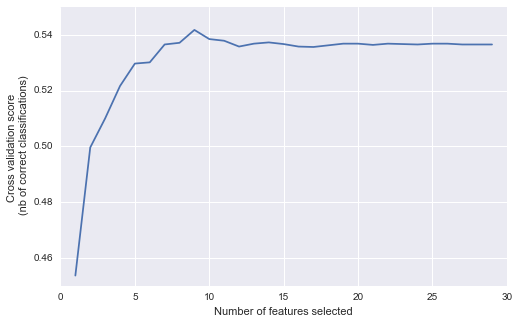

Random Forest
Optimal number of features : 12
Maximum accuracy : 0.661594%
Selected features: [ 3 12 14 15 16 17 18 19 20 26 27 28]


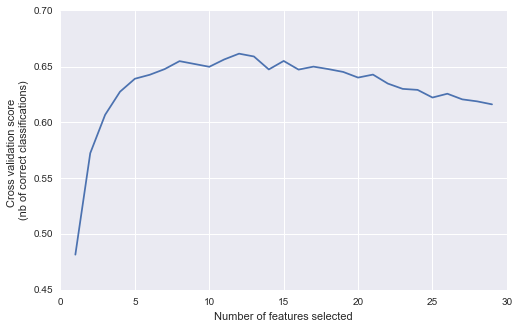

Linear SVM
Optimal number of features : 23
Maximum accuracy : 0.524579%
Selected features: [ 0  2  3  5  6  7  8 10 11 12 13 15 16 17 18 19 22 23 24 25 26 27 28]


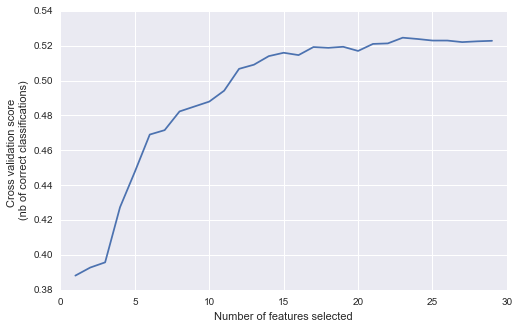

In [20]:
selected_features_physio = {}

for i in np.arange(len(classifiers)):
    clf = classifiers[i]
    rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(5),
                  scoring='accuracy')
    rfecv.fit(train_set_physio, train_label_physio)
    selected_features_physio[names[i]] = np.arange(train_set_physio.shape[1])[np.where(rfecv.ranking_ == 1)]
    print(names[i])
    print("Optimal number of features : %d" % rfecv.n_features_)
    print("Maximum accuracy : {0:4f}%".format(max(rfecv.grid_scores_)))
    print("Selected features: {}".format(selected_features_physio[names[i]]))
    
    # Plot number of features VS. cross-validation scores
    fig = plt.figure(figsize=[8, 5])
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score \n (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    fig.savefig('../results/plots/'+names[i]+' physio.png')
    plt.show()

### *Selection from all extracted features  (Unbalanced data)*

Decision Tree
Optimal number of features : 5
Maximum accuracy : 0.853138%
Selected features: [14 16 29 31 32]


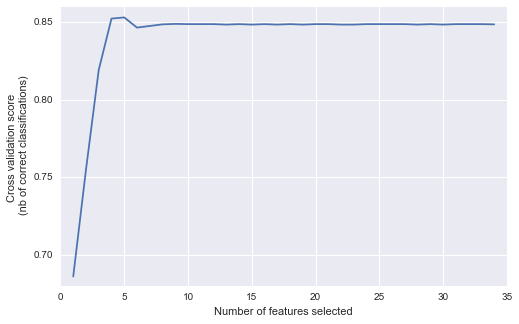

Random Forest
Optimal number of features : 10
Maximum accuracy : 0.874738%
Selected features: [16 17 18 20 25 28 29 30 31 32]


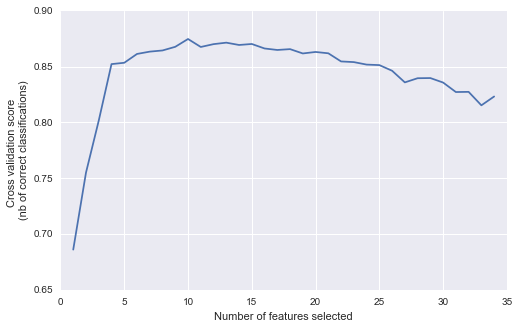

Linear SVM
Optimal number of features : 23
Maximum accuracy : 0.837352%
Selected features: [ 2  3  5  6  9 11 12 13 15 16 18 19 22 23 24 25 26 27 29 30 31 32 33]


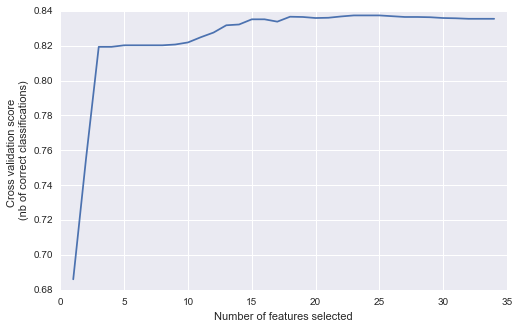

In [21]:
selected_features_all = {}

for i in np.arange(len(classifiers)):
    clf = classifiers[i]
    rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(5),
                  scoring='accuracy')
    rfecv.fit(train_set_all, train_label_all)
    selected_features_all[names[i]] = np.arange(train_set_all.shape[1])[np.where(rfecv.ranking_ == 1)]
    print(names[i])
    print("Optimal number of features : %d" % rfecv.n_features_)
    print("Maximum accuracy : {0:4f}%".format(max(rfecv.grid_scores_)))
    print("Selected features: {}".format(selected_features_all[names[i]]))
    
    # Plot number of features VS. cross-validation scores
    fig = plt.figure(figsize=[8, 5])
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score \n (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    fig.savefig('../results/plots/'+names[i]+' all.png')
    plt.show()

### *Selection of features from physiological signals alone (Balanced data)*

In [22]:
oversample_data_physio, oversample_label_physio = su.smote_all_minority(train_set_physio, train_label_physio)
train_set_smote_physio = []
train_label_smote_physio = []

for k in oversample_data_physio.keys():
    train_set_smote_physio.append(oversample_data_physio[k])
    train_label_smote_physio.append(oversample_label_physio[k])
    
train_set_smote_physio = np.vstack(train_set_smote_physio)
train_label_smote_physio = np.hstack(train_label_smote_physio)

Decision Tree
Optimal number of features : 13
Maximum accuracy : 0.499432%
Selected features: [ 0  2  6  7 12 14 15 17 18 22 24 25 28]


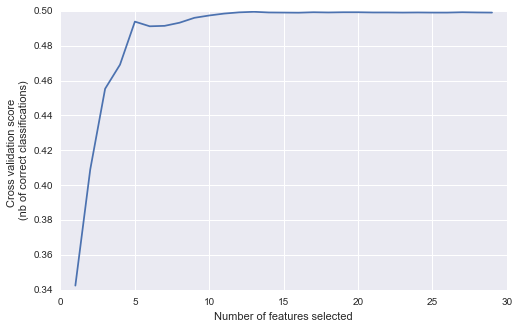

Random Forest
Optimal number of features : 14
Maximum accuracy : 0.792086%
Selected features: [ 0  2  4 12 15 16 17 18 19 20 22 23 27 28]


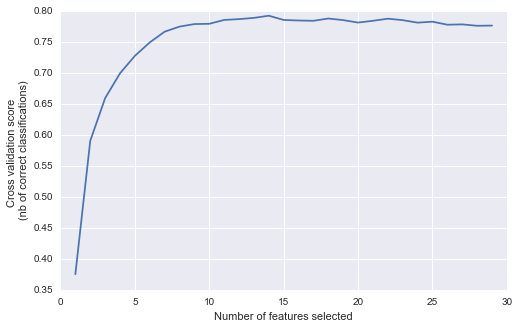

Linear SVM
Optimal number of features : 28
Maximum accuracy : 0.575600%
Selected features: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28]


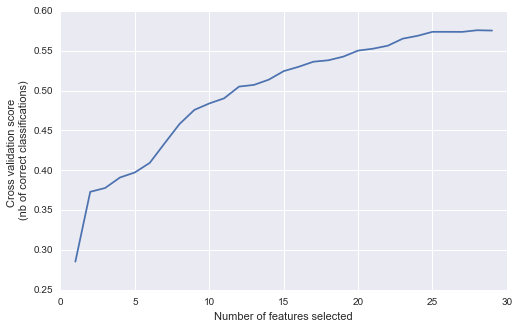

In [23]:
selected_features_smote_physio = {}

for i in np.arange(len(classifiers)):
    clf = classifiers[i]
    rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(5),
                  scoring='accuracy')
    rfecv.fit(train_set_smote_physio, train_label_smote_physio)
    selected_features_smote_physio[names[i]] = np.arange(train_set_smote_physio.shape[1])[np.where(rfecv.ranking_ == 1)]
    print(names[i])
    print("Optimal number of features : %d" % rfecv.n_features_)
    print("Maximum accuracy : {0:4f}%".format(max(rfecv.grid_scores_)))
    print("Selected features: {}".format(selected_features_smote_physio[names[i]]))
    
    # Plot number of features VS. cross-validation scores
    fig = plt.figure(figsize=[8, 5])
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score \n (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    fig.savefig('../results/plots/'+names[i]+' smote physio.png')
    plt.show()

### *Selection from all extracted features (Balanced data)*

In [24]:
oversample_data_all, oversample_label_all = su.smote_all_minority(train_set_all, train_label_all)
train_set_smote_all = []
train_label_smote_all = []

for k in oversample_data_all.keys():
    train_set_smote_all.append(oversample_data_all[k])
    train_label_smote_all.append(oversample_label_all[k])
    
train_set_smote_all = np.vstack(train_set_smote_all)
train_label_smote_all = np.hstack(train_label_smote_all)

Decision Tree
Optimal number of features : 17
Maximum accuracy : 0.895442%
Selected features: [16 17 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33]


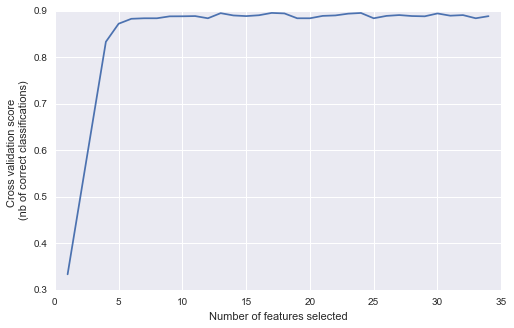

Random Forest
Optimal number of features : 13
Maximum accuracy : 0.934702%
Selected features: [ 5 16 18 19 20 22 24 27 29 30 31 32 33]


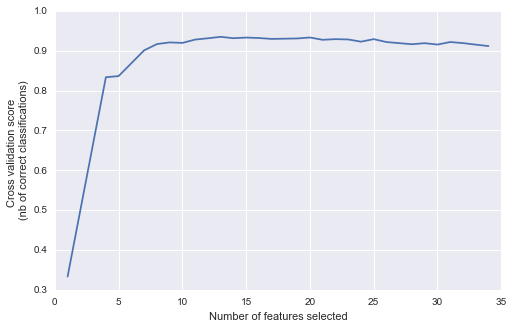

Linear SVM
Optimal number of features : 25
Maximum accuracy : 0.903173%
Selected features: [ 3  4  5  6  9 10 11 14 15 16 17 18 19 22 23 24 25 26 27 28 29 30 31 32 33]


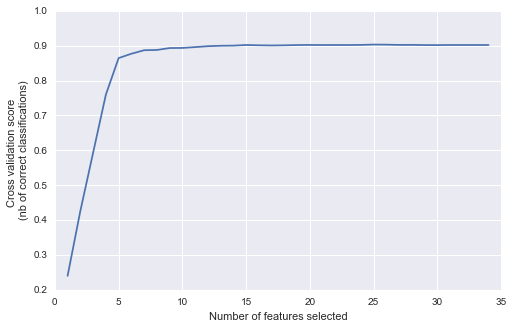

In [25]:
selected_features_smote_all = {}

for i in np.arange(len(classifiers)):
    clf = classifiers[i]
    rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(5),
                  scoring='accuracy')
    rfecv.fit(train_set_smote_all, train_label_smote_all)
    selected_features_smote_all[names[i]] = np.arange(train_set_smote_all.shape[1])[np.where(rfecv.ranking_ == 1)]
    print(names[i])
    print("Optimal number of features : %d" % rfecv.n_features_)
    print("Maximum accuracy : {0:4f}%".format(max(rfecv.grid_scores_)))
    print("Selected features: {}".format(selected_features_smote_all[names[i]]))
    
    # Plot number of features VS. cross-validation scores
    fig = plt.figure(figsize=[8, 5])
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score \n (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    fig.savefig('../results/plots/'+names[i]+' smote all.png')
    plt.show()

Observation: *Balancing the data improved the accuracy of the classification.*

## III. Model training

In [26]:
model_name = ["Nearest Neighbors", "Linear SVM", "RBF SVM", 
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

models = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

#### *Use selected features to train classifier*

In [27]:
k_fold = StratifiedKFold(5)

In [28]:
features = selected_features_smote_physio
train_set = train_set_smote_physio
train_label = train_label_smote_physio
test_set = test_set_physio
test_label = test_label_physio

In [29]:
val_accs_physio = []

In [30]:
best_trained_model_physio = []

for key in names: 
    idx_feats = features[key]
    print("Features used: {}".format(idx_feats))

    X = train_set[:, idx_feats]
    y = np.ndarray.flatten(train_label)
    
    best_mod_acc = 0
    for i in np.arange(len(models)):
        print(model_name[i])
        clf = models[i]
        
        time_start = time.time()
        
        best_cv_acc = 0
        for k, (train, test) in enumerate(k_fold.split(X, y)):
            clf.fit(X[train], y[train])
            val_acc = clf.score(X[test], y[test])
            if val_acc > best_cv_acc:
                best_model_cv = deepcopy(clf)
                best_cv_acc = val_acc
                        
        prediction = best_model_cv.predict(test_set[:, idx_feats])
        time_stop = time.time()
        
        runtime = time_stop - time_start # in seconds
        accuracy = 100*accuracy_score(test_label, prediction)
        print "\t Validation Accuracy: %.4f%%  Test Accuracy: %.4f%%  Test Runtime: %.4fs" % (best_cv_acc*100, accuracy, runtime)
        print('\n')
        
        val_accs_physio.append(best_cv_acc)
        
        best_trained_model_physio.append((idx_feats, model_name[i], best_model_cv, accuracy))


Features used: [ 0  2  6  7 12 14 15 17 18 22 24 25 28]
Nearest Neighbors
	 Validation Accuracy: 86.4683%  Test Accuracy: 59.2380%  Test Runtime: 1.4941s


Linear SVM
	 Validation Accuracy: 51.6955%  Test Accuracy: 39.7641%  Test Runtime: 23.5428s


RBF SVM
	 Validation Accuracy: 88.0358%  Test Accuracy: 63.9552%  Test Runtime: 57.7434s


Decision Tree
	 Validation Accuracy: 50.5438%  Test Accuracy: 39.0989%  Test Runtime: 0.4954s


Random Forest
	 Validation Accuracy: 59.5969%  Test Accuracy: 43.6650%  Test Runtime: 0.5686s


Neural Net
	 Validation Accuracy: 71.3052%  Test Accuracy: 53.8857%  Test Runtime: 24.4302s


AdaBoost
	 Validation Accuracy: 52.5912%  Test Accuracy: 37.2845%  Test Runtime: 7.2512s


Naive Bayes
	 Validation Accuracy: 45.4255%  Test Accuracy: 25.0076%  Test Runtime: 0.0452s


QDA
	 Validation Accuracy: 58.0294%  Test Accuracy: 34.4119%  Test Runtime: 0.0742s


Features used: [ 0  2  4 12 15 16 17 18 19 20 22 23 27 28]
Nearest Neighbors


/Users/eventura/anaconda/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


	 Validation Accuracy: 85.8605%  Test Accuracy: 62.4735%  Test Runtime: 0.7986s


Linear SVM
	 Validation Accuracy: 51.3116%  Test Accuracy: 39.9153%  Test Runtime: 25.0139s


RBF SVM
	 Validation Accuracy: 87.2041%  Test Accuracy: 65.9208%  Test Runtime: 48.8916s


Decision Tree
	 Validation Accuracy: 53.2310%  Test Accuracy: 36.9519%  Test Runtime: 0.5405s


Random Forest
	 Validation Accuracy: 61.9962%  Test Accuracy: 45.6305%  Test Runtime: 0.5742s


Neural Net
	 Validation Accuracy: 69.3218%  Test Accuracy: 53.6740%  Test Runtime: 17.6203s


AdaBoost
	 Validation Accuracy: 49.8081%  Test Accuracy: 35.4400%  Test Runtime: 7.0065s


Naive Bayes
	 Validation Accuracy: 42.0985%  Test Accuracy: 30.4808%  Test Runtime: 0.0452s


QDA
	 Validation Accuracy: 60.3327%  Test Accuracy: 39.8246%  Test Runtime: 0.0481s


Features used: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28]
Nearest Neighbors
	 Validation Accuracy: 87.6520%  Test Accuracy: 62.0200%

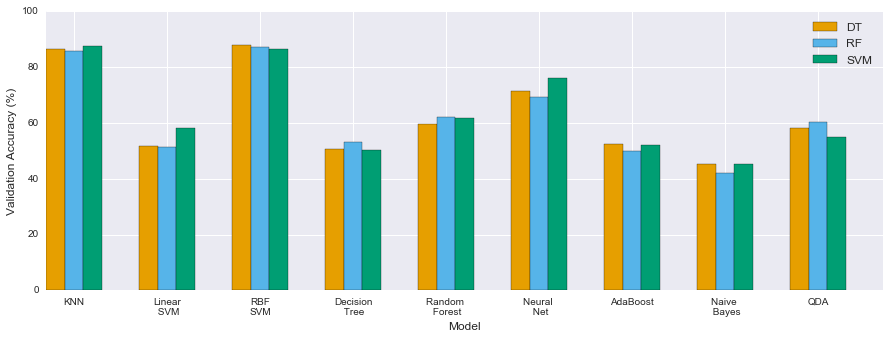

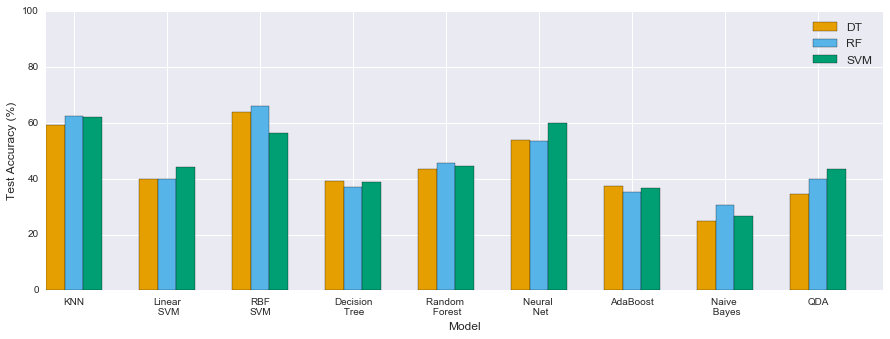

In [31]:
validation_accuracies_physio = np.reshape(val_accs_physio, [3, 9])*100
test_accuracies_physio = np.reshape(zip(*best_trained_model_physio)[3], [3, 9])

ind = np.arange(9)  # the x locations for the groups
width = 0.2  

plt.figure()
fig, ax = plt.subplots(figsize=[15, 5])
rects1 = ax.bar(ind, validation_accuracies_physio[0, :], width, color=[230/255, 159/255, 0/255])
rects2 = ax.bar(ind + width, validation_accuracies_physio[1, :], width, color=[86/255, 180/255, 233/255])
rects3 = ax.bar(ind + 2*width, validation_accuracies_physio[2, :], width, color=[0/255, 158/255, 115/255])
ax.set_xticks(ind + width*1.5)
# ax.set_yticks(fontsize = 12)
ax.set_xticklabels(('KNN', 'Linear\n SVM', 'RBF\nSVM', 'Decision\n Tree', 'Random \n Forest', 'Neural \n Net', 'AdaBoost', 'Naive \n Bayes', 'QDA'))
ax.set_xlabel("Model", fontsize = 12)
ax.set_ylabel("Validation Accuracy (%)", fontsize = 12)
ax.set_ylim(0, 100)
ax.legend((rects1[0], rects2[0], rects3[0]), ('DT', 'RF', 'SVM'), fontsize = 12)

plt.figure()
fig2, ax2 = plt.subplots(figsize=[15, 5])
rects1 = ax2.bar(ind, test_accuracies_physio[0, :], width, color=[230/255, 159/255, 0/255])
rects2 = ax2.bar(ind + width, test_accuracies_physio[1, :], width, color=[86/255, 180/255, 233/255])
rects3 = ax2.bar(ind + 2*width, test_accuracies_physio[2, :], width, color=[0/255, 158/255, 115/255])
ax2.set_xticks(ind + width*1.5)
# ax2.set_yticks(fontsize = 12)
ax2.set_xticklabels(('KNN', 'Linear\n SVM', 'RBF\nSVM', 'Decision\n Tree', 'Random \n Forest', 'Neural \n Net', 'AdaBoost', 'Naive \n Bayes', 'QDA'))
ax2.set_xlabel("Model", fontsize = 12)
ax2.set_ylabel("Test Accuracy (%)", fontsize = 12)
ax2.set_ylim(0, 100)
ax2.legend((rects1[0], rects2[0], rects3[0]), ('DT', 'RF', 'SVM'), fontsize = 12)



In [32]:
best_model_physio = best_trained_model_physio[np.argmax(zip(*best_trained_model_physio)[3])][2]
best_features_physio = best_trained_model_physio[np.argmax(zip(*best_trained_model_physio)[3])][0]

In [33]:
best_model_physio 

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=2, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [34]:
best_features_physio

array([ 0,  2,  4, 12, 15, 16, 17, 18, 19, 20, 22, 23, 27, 28])

In [35]:
## Visualize prediction
print(accuracy_score(test_label_physio, best_model_physio.predict(test_set_physio[:, best_features_physio])))
confusion_matrix(test_label_physio, best_model_physio.predict(test_set_physio[:, best_features_physio])) 

0.659207741155


array([[312,  95,  10,  11, 148,   1],
       [149, 724, 138,  55, 173,   1],
       [  2,  25, 179,   4,  19,   1],
       [ 16,  38,   6, 132,  43,   1],
       [113,  54,   8,   9, 833,   0],
       [  0,   2,   1,   0,   4,   0]])

** *Observations: * **

Highest test accuracy when the following features are used: 
* From respiration signal
    * Respiration rate
    * Minimum magnitude of resp
    * Maximum magnitude of resp
    * Mean vs stdev of amplitude of respiration signal of resp
    * Sample entropy of respiration signal of resp
    * Number of zero crossings of resp
    * Kurtosis of resp

* From ECG signal
    * Heart rate
    * Mean of ecg magnitudes
    * Minimum ecg magnitude
    * Maximum ecg magnitude
    * Standard deviation of ecg magnitude
    * Standard deviation vs mean of ecg magnitude
    * Max vs mean of amplitude of ecg signal
    * Sample entropy of ecg signal
    * Number of zero  in ecg
    * Kurtosis of ecg
    * Skewness of ecg
 

RBF SVM resulted to the best test accuracy of 66.82%. 

In [36]:
features = selected_features_smote_all
train_set = train_set_smote_all
train_label = train_label_smote_all
test_set = test_set_all
test_label = test_label_all

In [37]:
val_accs_all = []

In [38]:
best_model_cv

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001)

In [39]:
best_trained_model_all = []

for key in names: 
    idx_feats = features[key]
    print("Features used: {}".format(idx_feats))

    X = train_set[:, idx_feats]
    y = np.ndarray.flatten(train_label)
    
    best_mod_acc = 0
    for i in np.arange(len(models)):
        print(model_name[i])
        clf = models[i]
        
        time_start = time.time()
        
        best_cv_acc = 0
        for k, (train, test) in enumerate(k_fold.split(X, y)):
            clf.fit(X[train], y[train])
            val_acc = clf.score(X[test], y[test])
            if val_acc > best_cv_acc:
                best_model_cv = deepcopy(clf)
                best_cv_acc = val_acc
                        
        prediction = best_model_cv.predict(test_set[:, idx_feats])
        time_stop = time.time()
        
        runtime = time_stop - time_start # in seconds
        accuracy = 100*accuracy_score(test_label, prediction)
        print "\t Validation Accuracy: %.4f%%  Test Accuracy: %.4f%%  Test Runtime: %.4fs" % (best_cv_acc*100, accuracy, runtime)
        print('\n')
        val_accs_all.append(best_cv_acc)
        
        best_trained_model_all.append((idx_feats, model_name[i], best_model_cv, accuracy))


Features used: [16 17 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33]
Nearest Neighbors
	 Validation Accuracy: 94.8496%  Test Accuracy: 87.0880%  Test Runtime: 1.3237s


Linear SVM
	 Validation Accuracy: 89.2834%  Test Accuracy: 81.2821%  Test Runtime: 3.8362s


RBF SVM
	 Validation Accuracy: 94.0819%  Test Accuracy: 85.5761%  Test Runtime: 25.0367s


Decision Tree
	 Validation Accuracy: 91.3793%  Test Accuracy: 85.6970%  Test Runtime: 0.3736s


Random Forest
	 Validation Accuracy: 90.8509%  Test Accuracy: 83.2477%  Test Runtime: 0.5420s


Neural Net
	 Validation Accuracy: 91.2668%  Test Accuracy: 83.3384%  Test Runtime: 10.8293s


AdaBoost
	 Validation Accuracy: 83.3333%  Test Accuracy: 62.5038%  Test Runtime: 6.6536s


Naive Bayes
	 Validation Accuracy: 87.6200%  Test Accuracy: 82.4312%  Test Runtime: 0.0475s


QDA
	 Validation Accuracy: 84.9648%  Test Accuracy: 74.5691%  Test Runtime: 0.0597s


Features used: [ 5 16 18 19 20 22 24 27 29 30 31 32 33]
Nearest Neighbors
	 Validation Accu

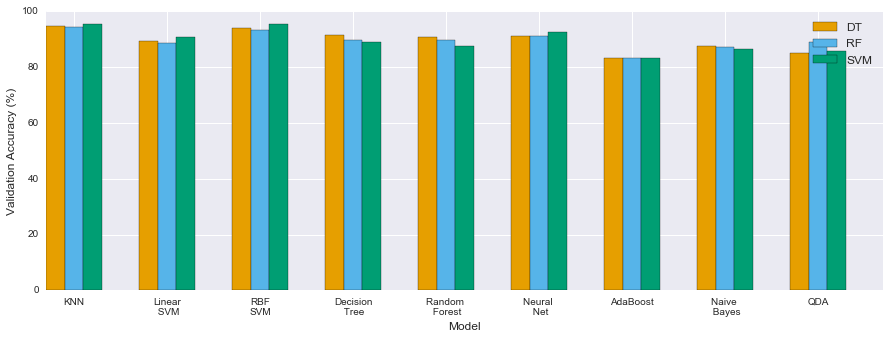

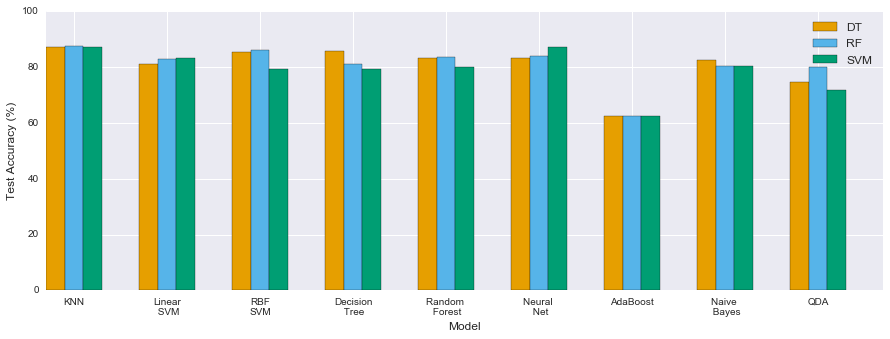

In [40]:
validation_accuracies_all = np.reshape(val_accs_all, [3, 9])*100
test_accuracies_all = np.reshape(zip(*best_trained_model_all)[3], [3, 9])

ind = np.arange(9)  # the x locations for the groups
width = 0.2  

plt.figure()
fig, ax = plt.subplots(figsize=[15, 5])
rects1 = ax.bar(ind, validation_accuracies_all[0, :], width, color=[230/255, 159/255, 0/255])
rects2 = ax.bar(ind + width, validation_accuracies_all[1, :], width, color=[86/255, 180/255, 233/255])
rects3 = ax.bar(ind + 2*width, validation_accuracies_all[2, :], width, color=[0/255, 158/255, 115/255])
ax.set_xticks(ind + width*1.5)
# ax.set_yticks(fontsize = 12)
ax.set_xticklabels(('KNN', 'Linear\n SVM', 'RBF\nSVM', 'Decision\n Tree', 'Random \n Forest', 'Neural \n Net', 'AdaBoost', 'Naive \n Bayes', 'QDA'))
ax.set_xlabel("Model", fontsize = 12)
ax.set_ylabel("Validation Accuracy (%)", fontsize = 12)
ax.set_ylim(0, 100)
ax.legend((rects1[0], rects2[0], rects3[0]), ('DT', 'RF', 'SVM'), fontsize = 12)

plt.figure()
fig2, ax2 = plt.subplots(figsize=[15, 5])
rects1 = ax2.bar(ind, test_accuracies_all[0, :], width, color=[230/255, 159/255, 0/255])
rects2 = ax2.bar(ind + width, test_accuracies_all[1, :], width, color=[86/255, 180/255, 233/255])
rects3 = ax2.bar(ind + 2*width, test_accuracies_all[2, :], width, color=[0/255, 158/255, 115/255])
ax2.set_xticks(ind + width*1.5)
# ax2.set_yticks(fontsize = 12)
ax2.set_xticklabels(('KNN', 'Linear\n SVM', 'RBF\nSVM', 'Decision\n Tree', 'Random \n Forest', 'Neural \n Net', 'AdaBoost', 'Naive \n Bayes', 'QDA'))
ax2.set_xlabel("Model", fontsize = 12)
ax2.set_ylabel("Test Accuracy (%)", fontsize = 12)
ax2.set_ylim(0, 100)
ax2.legend((rects1[0], rects2[0], rects3[0]), ('DT', 'RF', 'SVM'), fontsize = 12)



In [41]:
best_model_all = best_trained_model_all[np.argmax(zip(*best_trained_model_all)[3])][2]
best_features_all = best_trained_model_all[np.argmax(zip(*best_trained_model_all)[3])][0]

In [42]:
best_model_all

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [43]:
(best_features_all)

array([ 5, 16, 18, 19, 20, 22, 24, 27, 29, 30, 31, 32, 33])

In [44]:
## Visualize prediction
print(accuracy_score(test_label_all, best_model_all.predict(test_set_all[:, best_features_all])))
confusion_matrix(test_label_all, best_model_all.predict(test_set_all[:, best_features_all])) 

0.875415784699


array([[ 440,  137,    0,    0,    0,    0],
       [ 273,  965,    0,    0,    2,    0],
       [   0,    0,  230,    0,    0,    0],
       [   0,    0,    0,  236,    0,    0],
       [   0,    0,    0,    0, 1017,    0],
       [   0,    0,    0,    0,    0,    7]])

** *Observations: * **

Highest test accuracy when the following features are used: 
* From respiration signal
    * Minimum magnitude of resp
    * Standard deviation of resp magnitude
    * Mean vs stdev of amplitude of respiration signal
    * Kurtosis of resp

* From ECG signal
    * Mean of magnitude of ecg
    * Minimum of magnitude of ecg
    * Maximum of magnitude of ecg
    * Standard deviation vs mean of magnitude
    * Sample entropy of ecg 
    * Kurtosis of ecg 

* Form previous stage
    * NREM-light or not
    * NREM-deep or not
    * REM or not
    * Wake or not
     
KNN classifier resulted to the best test accuracy of 87.57%. 

In [51]:
# # ## Save models
pickle.dump(best_model_physio, open("sleep_stage_classifier_without_previousstage_updated.pkl", "wb" ))
pickle.dump(best_model_all, open("sleep_stage_classifier_with_previousstage_updated.pkl", "wb" ))

In [52]:
# ## Save test scale function
pickle.dump(np.vstack((Scaling_Function_physio.mean_[best_features_physio], Scaling_Function_physio.scale_[best_features_physio])).T, open("scaling_function_without_previousstage_updated.pkl", "wb" ))
pickle.dump(np.vstack((Scaling_Function_all.mean_[best_features_all], Scaling_Function_all.scale_[best_features_all])).T, open("scaling_function_with_previousstage_updated.pkl", "wb" ))